In [1]:
import os
import numpy as np
import pandas as pd
import random
import copy

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms import functional as F

import re
from collections import Counter
from transformers import (
    AutoConfig,
    AutoTokenizer, 
    AutoModel,
    AutoModelForSequenceClassification
)

from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
seed = 0
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed)

In [4]:
# Generator untuk DataLoader
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    """Fungsi untuk memastikan setiap worker memiliki seed yang sama"""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [5]:
judi_images_path = "/kaggle/input/gamblingdet-id/situsjudiid-full/judi"
nonjudi_images_path = "/kaggle/input/gamblingdet-id/situsjudiid-full/non-judi"

train_csv_path = '/kaggle/input/train-test/train_data.csv'
test_csv_path = '/kaggle/input/train-test/test_data.csv'

In [6]:
# Load data
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
train_df

,File Name,Extracted Text,Class
0,ahoyamigo.com_home.png,KASKUSTOTO LOGIN KASKUSTOTO oiocom KASKUSTOTO ...,judi
1,asgard789.bet.png,SUCKBET kunusn Tusluju Unajv ]acipısı aüns I...,judi
2,bola442.monster.png,AsF User Name Password Code 6636 LOGIN Lela442...,judi
3,maniac-ihokibet.com_page1.png,Download APK Live Chat Hubungı Kamı Lupa Kata ...,judi
4,ketohour.com_page4.png,ketohour Beranda 7 @ Q Subscribe Beranda Situs...,judi
...,...,...,...
3340,bankmandiri.co.id_home.png,Ketik untuk mencari Log In mandırı Perseoranga...,non-judi
3341,bengkaliskab.go.id_page3.png,"JL Ahmad Yani, Bengkalis Kota Selamat datang d...",non-judi
3342,bsmentertainment.com_page9.png,021-22792541 CallWva 08111306600 (Jakarta) | C...,non-judi
3343,coinmarketcap.com_page5.png,CoinMarketCap Cryptocurrencies DexScan Exchang...,non-judi


In [7]:
# Drop missing values
print('Missing values in Train:\n', train_df.isna().sum())
train_df = train_df.dropna()

Missing values in Train:
 File Name         0
Extracted Text    0
Class             0
dtype: int64


In [8]:
# Add function to get full image path based on class
def get_image_path(filename, class_label):
    if class_label == 'judi':
        return os.path.join(judi_images_path, filename)
    else:  # non-judi
        return os.path.join(nonjudi_images_path, filename)

In [9]:
import re

def clean_texts(texts):
    cleaned_texts = []

    # Kata 1–2 huruf yang penting dan tidak boleh dihapus
    exceptions = {"di", "ke", "ya", "jl"}

    for text in texts:
        # ----- BASIC CLEANING -----
        text = re.sub(r"http\S+", "", text)                    # Hapus URL
        text = re.sub(r"\n", " ", text)                        # Ganti newline dengan spasi
        text = re.sub(r"[^a-zA-Z]", " ", text)             # Sisakan huruf, angka, apostrof
        text = re.sub(r"\s{2,}", " ", text).strip().lower()    # Hapus spasi ganda & ke lowercase

        # ----- FILTERING -----
        words = text.split()
        filtered_words = [
            w for w in words
            if (len(w) > 2 or w in exceptions)
            and not re.fullmatch(r"[aeiou]{3,}", w)            # Hindari vokal berulang ("aaa")
            and not re.fullmatch(r"[bcdfghjklmnpqrstvwxyz]{3,}", w)  # Hindari konsonan berulang ("kkk")
            and len(w) <= 20                                   # Batasi kata terlalu panjang
        ]

        cleaned_texts.append(" ".join(filtered_words))

    return cleaned_texts

In [10]:
# Bersihkan teks
train_df['cleaned_text'] = clean_texts(train_df['Extracted Text'])
test_df['cleaned_text'] = clean_texts(test_df['Extracted Text'])

In [11]:
# Drop rows with less than 5 words
train_df = train_df[train_df['cleaned_text'].apply(lambda x: len(str(x).split()) >= 5)]
test_df = test_df[test_df['cleaned_text'].apply(lambda x: len(str(x).split()) >= 5)]
train_df

,File Name,Extracted Text,Class,cleaned_text
0,ahoyamigo.com_home.png,KASKUSTOTO LOGIN KASKUSTOTO oiocom KASKUSTOTO ...,judi,kaskustoto login kaskustoto oiocom kaskustoto ...
1,asgard789.bet.png,SUCKBET kunusn Tusluju Unajv ]acipısı aüns I...,judi,suckbet kunusn tusluju unajv acip augn
2,bola442.monster.png,AsF User Name Password Code 6636 LOGIN Lela442...,judi,asf user name password code login lela live ch...
3,maniac-ihokibet.com_page1.png,Download APK Live Chat Hubungı Kamı Lupa Kata ...,judi,download apk live chat hubung kam lupa kata sa...
4,ketohour.com_page4.png,ketohour Beranda 7 @ Q Subscribe Beranda Situs...,judi,ketohour beranda subscribe beranda situs togel...
...,...,...,...,...
3340,bankmandiri.co.id_home.png,Ketik untuk mencari Log In mandırı Perseoranga...,non-judi,ketik untuk mencari log mand perseorangan bisn...
3341,bengkaliskab.go.id_page3.png,"JL Ahmad Yani, Bengkalis Kota Selamat datang d...",non-judi,jl ahmad yani bengkalis kota selamat datang di...
3342,bsmentertainment.com_page9.png,021-22792541 CallWva 08111306600 (Jakarta) | C...,non-judi,callwva jakarta call wva bandurg office hours ...
3343,coinmarketcap.com_page5.png,CoinMarketCap Cryptocurrencies DexScan Exchang...,non-judi,coinmarketcap cryptocurrencies dexscan exchang...


In [12]:
# Cek jumlah duplikasi sebelum dihapus
print("Duplikasi di train:", train_df.duplicated(subset='cleaned_text').sum())
print("Duplikasi di test :", test_df.duplicated(subset='cleaned_text').sum())

# Hapus duplikasi berdasarkan cleaned_text
train_df = train_df.drop_duplicates(subset='cleaned_text').reset_index(drop=True)
test_df = test_df.drop_duplicates(subset='cleaned_text').reset_index(drop=True)

# Cek ulang setelah pembersihan
print("Setelah dihapus:")
print("Train:", len(train_df), "baris")
print("Test :", len(test_df), "baris")

Duplikasi di train: 8
Duplikasi di test : 0
Setelah dihapus:
Train: 3335 baris
Test : 700 baris


In [13]:
# Print jumlah per kelas
print("Distribusi label di Train set:")
print(train_df['Class'].value_counts(), '\n')

print("Distribusi label di Test set:")
print(test_df['Class'].value_counts())

Distribusi label di Train set:
Class
non-judi    1740
judi        1595
Name: count, dtype: int64 

Distribusi label di Test set:
Class
judi        350
non-judi    350
Name: count, dtype: int64


In [14]:
from sklearn.utils import resample

# Pisahkan data berdasarkan kelas
train_judi = train_df[train_df['Class'] == 'judi']
train_nonjudi = train_df[train_df['Class'] == 'non-judi']

# Undersampling kelas mayoritas (non-judi) agar jumlahnya sama dengan kelas judi
train_nonjudi_undersampled = resample(train_nonjudi,
                                      replace=False,      # tanpa duplikasi
                                      n_samples=len(train_judi),  # samakan jumlahnya dengan kelas minoritas
                                      random_state=seed)    # untuk replikasi hasil

# Gabungkan kembali data yang sudah diundersample
train_df_balanced = pd.concat([train_judi, train_nonjudi_undersampled])

# Cek distribusi baru
print("Distribusi label setelah undersampling:")
print(train_df_balanced['Class'].value_counts())

Distribusi label setelah undersampling:
Class
judi        1595
non-judi    1595
Name: count, dtype: int64


In [15]:
label_map = {
    "non-judi": 0,
    "judi": 1
}

train_df_balanced['label'] = train_df_balanced['Class'].map(label_map)
test_df['label'] = test_df['Class'].map(label_map)

train_df_balanced['image'] = train_df_balanced['File Name']
test_df['image'] = test_df['File Name']

In [16]:
traindf, validdf = train_test_split(
    train_df_balanced, test_size=0.2, stratify=train_df_balanced['label'], random_state=seed
)

print(f"Jumlah data train: {len(traindf)}")
print(f"Jumlah data valid: {len(validdf)}")
print(f"Jumlah data test: {len(test_df)}")

Jumlah data train: 2552
Jumlah data valid: 638
Jumlah data test: 700


In [17]:
# Print jumlah per kelas
print("Distribusi label di Train set:")
print(traindf['label'].value_counts(), '\n')

print("Distribusi label di Validation set:")
print(validdf['label'].value_counts(), '\n')

print("Distribusi label di Test set:")
print(test_df['label'].value_counts())

Distribusi label di Train set:
label
1    1276
0    1276
Name: count, dtype: int64 

Distribusi label di Validation set:
label
0    319
1    319
Name: count, dtype: int64 

Distribusi label di Test set:
label
1    350
0    350
Name: count, dtype: int64


In [18]:
class ResizePadToSquare:
    def __init__(self, target_size=300):
        self.target_size = target_size

    def __call__(self, img):
        img = img.convert("RGB")
        # Resize dengan thumbnail: jaga rasio, resize sisi terpanjang ke target
        img.thumbnail((self.target_size, self.target_size), Image.BILINEAR)
        # Padding agar menjadi square
        delta_w = self.target_size - img.size[0]
        delta_h = self.target_size - img.size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        img = F.pad(img, padding, fill=0, padding_mode='constant')
        return img

In [19]:
transform_train = transforms.Compose([
    ResizePadToSquare(300),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    ResizePadToSquare(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [20]:
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
max_length= 128

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [21]:
class CustomCombinedDataset(Dataset):
    def __init__(self, dataframe, images_path_judi, images_path_non_judi, tokenizer, max_length, transforms=None):
        self.dataframe = dataframe.reset_index(drop=True)  # Reset index to avoid KeyError
        self.images_path_judi = images_path_judi
        self.images_path_non_judi = images_path_non_judi
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transforms = transforms
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img_name = row['image']
        label = row['label']
        text = str(row['cleaned_text'])
        
        # Tentukan path berdasarkan label
        if label == 1:  # judi
            img_path = os.path.join(self.images_path_judi, img_name)
        else:  # non-judi (label == 0)
            img_path = os.path.join(self.images_path_non_judi, img_name)
        
        image = Image.open(img_path)
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
            padding='max_length'
        )
        
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long),
            'filename': img_name
        }

In [22]:
# Update inisialisasi dataset dengan kedua path
combined_train_dataset = CustomCombinedDataset(traindf, judi_images_path, nonjudi_images_path, tokenizer, max_length, transforms=transform_train)
combined_valid_dataset = CustomCombinedDataset(validdf, judi_images_path, nonjudi_images_path, tokenizer, max_length, transforms=transform_test)
combined_test_dataset = CustomCombinedDataset(test_df, judi_images_path, nonjudi_images_path, tokenizer, max_length, transforms=transform_test)

In [23]:
batch_size = 16
combined_train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g)
combined_valid_loader = DataLoader(combined_valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g)

In [24]:
image_model_path = "/kaggle/input/gamblingwebi-v16/best_image_model_Adam_lr0.0001_bs16_state_dict.pt"
text_model_path = "/kaggle/input/gamblingwebt-v16/best_text_model_bs32_lr3e-05_ep3_state_dict.pt"

In [25]:
# Inisialisasi ulang model
image_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
num_features = image_model.classifier[1].in_features
image_model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_features, 1)
)

# Load state dict
image_model.load_state_dict(torch.load(image_model_path, map_location=device))
image_model.to(device)
image_model.eval()

# Inisialisasi ulang model
text_model = AutoModelForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1',
    num_labels=1
)

# Load state dict
text_model.load_state_dict(torch.load(text_model_path, map_location=device))
text_model.to(device)
text_model.eval()

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 212MB/s]
2025-08-03 04:21:21.382355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754194881.568952      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754194881.625374      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [26]:
# Define function to evaluate image model
def evaluate_image_model(model, data_loader):
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating Image Model"):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(images).squeeze(1)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    metrics = {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds),
        'Recall': recall_score(all_labels, all_preds),
        'F1 Score': f1_score(all_labels, all_preds),
        'ConfusionMatrix': confusion_matrix(all_labels, all_preds)
    }
    return metrics

In [27]:
print("\n===== IMAGE MODEL EVALUATION =====")
image_metrics = evaluate_image_model(image_model, combined_test_loader)
print("\nTest Set Metrics:")
for metric_name, value in image_metrics.items():
    if metric_name != 'ConfusionMatrix':
        print(f"  {metric_name}: {value:.4f}")


===== IMAGE MODEL EVALUATION =====


Evaluating Image Model: 100%|██████████| 44/44 [00:31<00:00,  1.38it/s]


Test Set Metrics:
  Accuracy: 0.9729
  Precision: 0.9688
  Recall: 0.9771
  F1 Score: 0.9730


In [28]:
def evaluate_text_model(model, data_loader):
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating Text Model"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits.squeeze(1)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    return {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds),
        'Recall': recall_score(all_labels, all_preds),
        'F1 Score': f1_score(all_labels, all_preds),
        'ConfusionMatrix': confusion_matrix(all_labels, all_preds)
    }

In [29]:
class MLPFusionModel(nn.Module):
    def __init__(self, image_model, text_model, hidden_dim=16, dropout_rate=0.2):
        super(MLPFusionModel, self).__init__()
        self.image_model = image_model
        self.text_model = text_model
        
        # Freeze the pre-trained models
        for param in self.image_model.parameters():
            param.requires_grad = False
        for param in self.text_model.parameters():
            param.requires_grad = False
            
        # MLP fusion layers
        # Input dimension: 2 (image logit + text logit)
        self.fusion_mlp = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1) 
        )
        
        # Initialize MLP weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initialize MLP weights using Xavier initialization"""
        for module in self.fusion_mlp:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)
    
    def forward(self, images, input_ids, attention_mask):
        # Get predictions from individual models (no gradients needed)
        with torch.no_grad():
            image_logits = self.image_model(images).squeeze(1)
            text_logits = self.text_model(input_ids=input_ids, attention_mask=attention_mask).logits.squeeze(1)
        
        # Concatenate logits as input to MLP
        # Shape: (batch_size, 2)
        combined_features = torch.stack([image_logits, text_logits], dim=1)
        
        # Pass through MLP for fusion
        fused_logits = self.fusion_mlp(combined_features).squeeze(1)
        
        return fused_logits, image_logits, text_logits

In [30]:
print("\n===== TEXT MODEL EVALUATION =====")
text_metrics = evaluate_text_model(text_model, combined_test_loader)
print("\nTest Set Metrics:")
for metric_name, value in text_metrics.items():
    if metric_name != 'ConfusionMatrix':
        print(f"  {metric_name}: {value:.4f}")


===== TEXT MODEL EVALUATION =====


Evaluating Text Model: 100%|██████████| 44/44 [00:26<00:00,  1.69it/s]


Test Set Metrics:
  Accuracy: 0.9857
  Precision: 0.9885
  Recall: 0.9829
  F1 Score: 0.9857


In [31]:
# Initialize the MLP fusion model
fusion_model = MLPFusionModel(image_model, text_model, hidden_dim=16, dropout_rate=0.2)
fusion_model.to(device)

# Training parameters - only MLP parameters are trainable
optimizer = optim.Adam(fusion_model.fusion_mlp.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [32]:
def train_mlp_fusion_model(fusion_model, train_loader, valid_loader, criterion, optimizer, device, fusion_epochs=10, patience=5):
    best_loss = float('inf')
    best_model_state = None
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    patience_counter = 0
    early_stopped = False

    for epoch in range(fusion_epochs):
        # === TRAINING ===
        fusion_model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].float().to(device)

            optimizer.zero_grad()
            fused_logits, _, _ = fusion_model(images, input_ids, attention_mask)
            loss = criterion(fused_logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(fusion_model.fusion_mlp.parameters(), max_norm=1.0)
            optimizer.step()

            total_train_loss += loss.item()

            preds = (torch.sigmoid(fused_logits) > 0.5).long()
            correct_train += (preds.squeeze() == labels.long()).sum().item()
            total_train += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # === VALIDATION ===
        fusion_model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in tqdm(valid_loader, desc=f"[Epoch {epoch+1}] Validation", leave=False):
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].float().to(device)

                fused_logits, _, _ = fusion_model(images, input_ids, attention_mask)
                loss = criterion(fused_logits, labels)
                total_val_loss += loss.item()

                preds = (torch.sigmoid(fused_logits) > 0.5).long()
                correct_val += (preds.squeeze() == labels.long()).sum().item()
                total_val += labels.size(0)

        avg_val_loss = total_val_loss / len(valid_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # === Early Stopping ===
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = fusion_model.state_dict()  # tidak perlu .copy()
            torch.save(best_model_state, 'best_mlp_fusion_model_state_dict.pt')
            patience_counter = 0
            print(f"Epoch {epoch+1}/{fusion_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | ✅ Best model saved!")
        else:
            patience_counter += 1
            print(f"Epoch {epoch+1}/{fusion_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"\n🛑 Early stopping at epoch {epoch+1}. No improvement for {patience} epochs.")
                early_stopped = True
                break

    if best_model_state is not None:
        fusion_model.load_state_dict(best_model_state)
        print(f"\n✅ Loaded best model with validation loss: {best_loss:.4f}")

    print(f"🔍 Best Validation Loss: {best_loss:.4f}")
    return train_losses, val_losses, train_accuracies, val_accuracies

In [33]:
# Train the MLP fusion model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_mlp_fusion_model(
    fusion_model=fusion_model,
    train_loader=combined_train_loader,
    valid_loader=combined_valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    fusion_epochs=15,
    patience=3
)

[Epoch 1] Training: 100%|██████████| 160/160 [02:15<00:00,  1.18it/s]


Epoch 1/15 | Train Loss: 1.1429 | Val Loss: 0.7058 | ✅ Best model saved!


[Epoch 2] Training: 100%|██████████| 160/160 [01:54<00:00,  1.40it/s]


Epoch 2/15 | Train Loss: 0.7170 | Val Loss: 0.3884 | ✅ Best model saved!


[Epoch 3] Training: 100%|██████████| 160/160 [01:54<00:00,  1.40it/s]


Epoch 3/15 | Train Loss: 0.3921 | Val Loss: 0.1086 | ✅ Best model saved!


[Epoch 4] Training: 100%|██████████| 160/160 [01:54<00:00,  1.40it/s]


Epoch 4/15 | Train Loss: 0.2264 | Val Loss: 0.0588 | ✅ Best model saved!


[Epoch 5] Training: 100%|██████████| 160/160 [01:52<00:00,  1.42it/s]


Epoch 5/15 | Train Loss: 0.1041 | Val Loss: 0.0429 | ✅ Best model saved!


[Epoch 6] Training: 100%|██████████| 160/160 [01:52<00:00,  1.42it/s]


Epoch 6/15 | Train Loss: 0.0830 | Val Loss: 0.0357 | ✅ Best model saved!


[Epoch 7] Training: 100%|██████████| 160/160 [01:52<00:00,  1.42it/s]


Epoch 7/15 | Train Loss: 0.0580 | Val Loss: 0.0366 | Patience: 1/3


[Epoch 8] Training: 100%|██████████| 160/160 [01:55<00:00,  1.39it/s]


Epoch 8/15 | Train Loss: 0.0491 | Val Loss: 0.0352 | ✅ Best model saved!


[Epoch 9] Training: 100%|██████████| 160/160 [01:55<00:00,  1.39it/s]


Epoch 9/15 | Train Loss: 0.0365 | Val Loss: 0.0352 | ✅ Best model saved!


[Epoch 10] Training: 100%|██████████| 160/160 [01:55<00:00,  1.38it/s]


Epoch 10/15 | Train Loss: 0.0394 | Val Loss: 0.0348 | ✅ Best model saved!


[Epoch 11] Training: 100%|██████████| 160/160 [01:55<00:00,  1.38it/s]


Epoch 11/15 | Train Loss: 0.0253 | Val Loss: 0.0364 | Patience: 1/3


[Epoch 12] Training: 100%|██████████| 160/160 [01:55<00:00,  1.38it/s]


Epoch 12/15 | Train Loss: 0.0199 | Val Loss: 0.0358 | Patience: 2/3


[Epoch 13] Training: 100%|██████████| 160/160 [01:55<00:00,  1.38it/s]
                                                                      

Epoch 13/15 | Train Loss: 0.0192 | Val Loss: 0.0352 | Patience: 3/3

🛑 Early stopping at epoch 13. No improvement for 3 epochs.

✅ Loaded best model with validation loss: 0.0348
🔍 Best Validation Loss: 0.0348


In [34]:
# Load best model for evaluation
fusion_model = MLPFusionModel(image_model, text_model)
fusion_model.load_state_dict(torch.load('best_mlp_fusion_model_state_dict.pt', map_location=device))
fusion_model.to(device)
fusion_model.eval()

MLPFusionModel(
  (image_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
             

In [35]:
import time

def evaluate_mlp_fusion_model(fusion_model, data_loader):
    fusion_model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    start_time = time.time()  # Mulai pencatatan waktu
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating MLP Fusion Model"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            fused_logits, _, _ = fusion_model(images, input_ids, attention_mask)
            fused_probs = torch.sigmoid(fused_logits).cpu().numpy()
            fused_preds = (fused_probs > 0.5).astype(int)
            
            all_preds.extend(fused_preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(fused_probs)
    
    end_time = time.time()
    total_time = end_time - start_time
    avg_time_per_sample = total_time / len(data_loader.dataset)
    
    print(f"\nTotal inference time: {total_time:.2f} seconds")
    print(f"Average time per sample: {avg_time_per_sample * 1000:.2f} ms")
    
    return {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds),
        'Recall': recall_score(all_labels, all_preds),
        'F1 Score': f1_score(all_labels, all_preds),
        'AUC': roc_auc_score(all_labels, all_probs),  # Use probabilities for AUC
        'ConfusionMatrix': confusion_matrix(all_labels, all_preds),
        'InferenceTime': total_time,
        'TimePerSample': avg_time_per_sample
    }

In [36]:
print("\n===== MLP FUSION MODEL EVALUATION =====")
fusion_metrics = evaluate_mlp_fusion_model(fusion_model, combined_test_loader)

print("\nTest Set Metrics:")
for metric_name, value in fusion_metrics.items():
    if metric_name != 'ConfusionMatrix':
        print(f"  {metric_name}: {value:.4f}")


===== MLP FUSION MODEL EVALUATION =====


Evaluating MLP Fusion Model: 100%|██████████| 44/44 [00:28<00:00,  1.55it/s]


Total inference time: 28.32 seconds
Average time per sample: 40.46 ms

Test Set Metrics:
  Accuracy: 0.9971
  Precision: 0.9971
  Recall: 0.9971
  F1 Score: 0.9971
  AUC: 0.9999
  InferenceTime: 28.3241
  TimePerSample: 0.0405


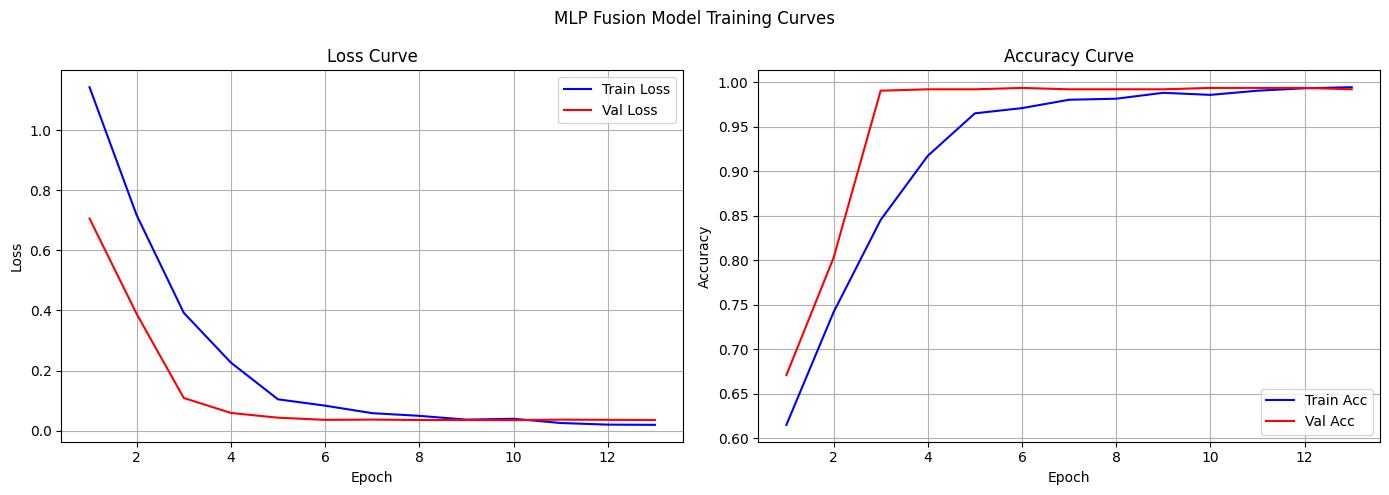

In [37]:
# Optional: Plot training curves
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axs[0].plot(epochs, train_losses, 'b-', label='Train Loss')
    axs[0].plot(epochs, val_losses, 'r-', label='Val Loss')
    axs[0].set_title('Loss Curve')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Accuracy
    axs[1].plot(epochs, train_accuracies, 'b-', label='Train Acc')
    axs[1].plot(epochs, val_accuracies, 'r-', label='Val Acc')
    axs[1].set_title('Accuracy Curve')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle('MLP Fusion Model Training Curves')
    plt.tight_layout()
    plt.show()

plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [38]:
# Tampilkan semua confusion matrix
def plot_confusion_matrices(cm_dict):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    titles = ["Fusion Model", "Image Model", "Text Model"]
    
    for ax, (model_name, cm), title in zip(axes, cm_dict.items(), titles):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix: {title}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    
    plt.tight_layout()
    plt.show()

# Dictionary dengan CM semua model
conf_matrices = {
    'fusion': fusion_metrics['ConfusionMatrix'],
    'image': image_metrics['ConfusionMatrix'],
    'text': text_metrics['ConfusionMatrix']
}

In [39]:
# Create a DataFrame to easily compare all models
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Fusion Model': [fusion_metrics['Accuracy'], fusion_metrics['Precision'], 
                    fusion_metrics['Recall'], fusion_metrics['F1 Score']],
    'Image Model': [image_metrics['Accuracy'], image_metrics['Precision'], 
                   image_metrics['Recall'], image_metrics['F1 Score']],
    'Text Model': [text_metrics['Accuracy'], text_metrics['Precision'], 
                  text_metrics['Recall'], text_metrics['F1 Score']]
})

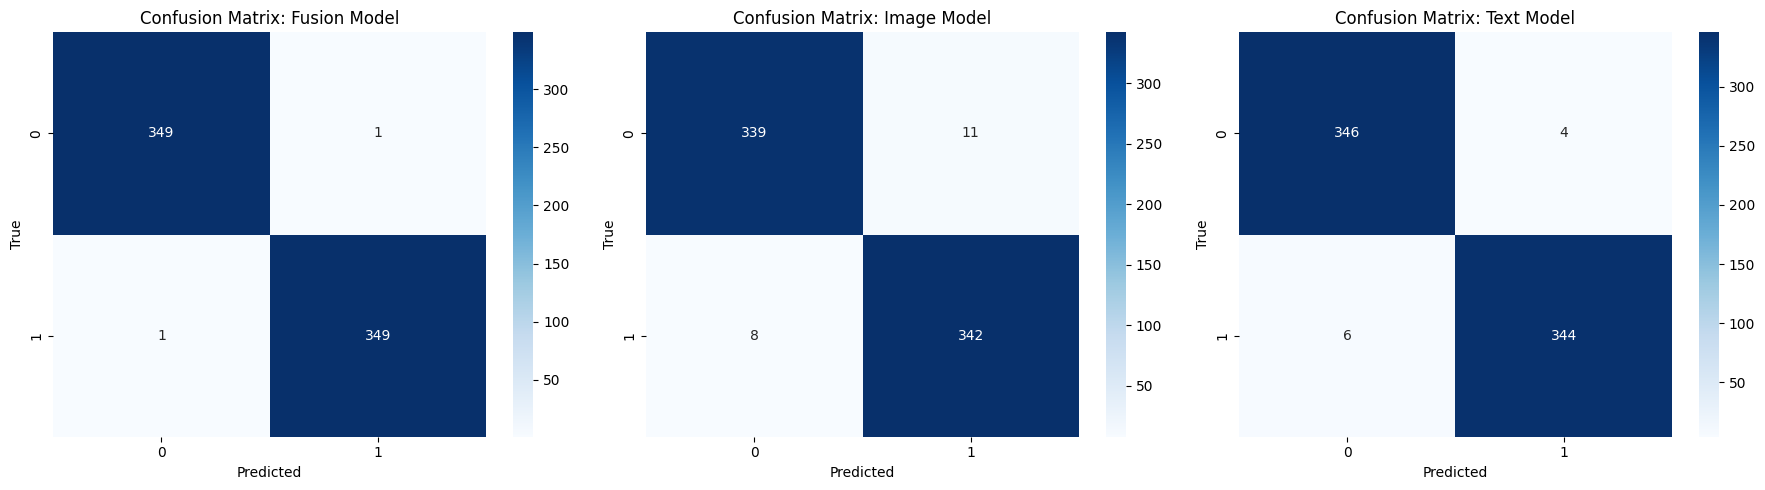


===== MODEL COMPARISON =====
   Metric  Fusion Model  Image Model  Text Model
 Accuracy        0.9971       0.9729      0.9857
Precision        0.9971       0.9688      0.9885
   Recall        0.9971       0.9771      0.9829
 F1 Score        0.9971       0.9730      0.9857


In [40]:
# Display the Confusion Matrix
plot_confusion_matrices(conf_matrices)

# Display the comparison table with 4 decimal places
print("\n===== MODEL COMPARISON =====")
print(comparison_df.round(4).to_string(index=False))

In [41]:
def evaluate_and_show_errors(fusion_model, data_loader, device, tokenizer, num_samples_to_show=10):
    fusion_model.eval()

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    def unnormalize(tensor, mean, std):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor

    fusion_correct_image_wrong = []  # Fusion benar, image salah
    fusion_correct_text_wrong = []   # Fusion benar, text salah
    fusion_wrong = []                # Fusion salah

    with torch.no_grad():
        for batch_data in tqdm(data_loader, desc="Evaluating Fusion Model"):
            images = batch_data['image'].to(device)
            input_ids = batch_data['input_ids'].to(device)
            attention_mask = batch_data['attention_mask'].to(device)
            labels = batch_data['label'].to(device)

            fused_logits, image_logits, text_logits = fusion_model(images, input_ids, attention_mask)

            fused_probs = torch.sigmoid(fused_logits)
            image_probs = torch.sigmoid(image_logits)
            text_probs = torch.sigmoid(text_logits)

            fused_preds = (fused_probs > 0.5).long()
            image_preds = (image_probs > 0.5).long()
            text_preds = (text_probs > 0.5).long()

            for i in range(images.size(0)):
                label = labels[i].item()
                fusion_pred = fused_preds[i].item()
                image_pred = image_preds[i].item()
                text_pred = text_preds[i].item()

                entry = {
                    "image": images[i].cpu(),
                    "input_ids": input_ids[i].cpu(),
                    "label": label,
                    "image_pred": image_pred,
                    "text_pred": text_pred,
                    "fusion_pred": fusion_pred,
                    "image_prob": image_probs[i].item(),
                    "text_prob": text_probs[i].item(),
                    "fusion_prob": fused_probs[i].item(),
                    "filename": batch_data["filename"][i]
                }

                # Fusion benar, image salah
                if fusion_pred == label and image_pred != label:
                    fusion_correct_image_wrong.append(entry)
                # Fusion benar, text salah
                if fusion_pred == label and text_pred != label:
                    fusion_correct_text_wrong.append(entry)
                # Fusion salah
                if fusion_pred != label:
                    fusion_wrong.append(entry)

    print(f"\n[INFO] ✅ Fusion benar & image salah: {len(fusion_correct_image_wrong)}")
    print(f"[INFO] ✅ Fusion benar & text salah : {len(fusion_correct_text_wrong)}")
    print(f"[INFO] ❌ Fusion salah prediksi     : {len(fusion_wrong)}\n")

    def display_samples(samples, title_prefix):
        for idx, sample in enumerate(samples[:num_samples_to_show]):
            img_tensor = unnormalize(sample["image"].clone(), mean, std)
            img_np = img_tensor.permute(1, 2, 0).numpy().clip(0, 1)
            text_decoded = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)

            plt.figure(figsize=(4, 4))
            plt.imshow(img_np)
            plt.axis('off')
            plt.title(f"{title_prefix} #{idx+1}")
            plt.show()

            print(f"[FILE]: {sample['filename']}")
            print(f"[TEXT]: {text_decoded}")
            print(f"[LABEL]: {sample['label']}")
            print(f"[PRED - Fusion]: {sample['fusion_pred']} (Prob: {sample['fusion_prob']:.4f})")
            print(f"[PRED - Image ]: {sample['image_pred']} (Prob: {sample['image_prob']:.4f})")
            print(f"[PRED - Text  ]: {sample['text_pred']} (Prob: {sample['text_prob']:.4f})")
            print("-" * 60)

    print("\n========== ✅ Fusion BENAR & IMAGE SALAH ==========")
    display_samples(fusion_correct_image_wrong, title_prefix="Fusion Benar & Image Salah")

    print("\n========== ✅ Fusion BENAR & TEXT SALAH ==========")
    display_samples(fusion_correct_text_wrong, title_prefix="Fusion Benar & Text Salah")

    print("\n========== ❌ Fusion SALAH ==========")
    display_samples(fusion_wrong, title_prefix="Fusion Salah")

In [42]:
# Evaluasi individual models jika belum ada
def evaluate_individual_models(image_model, text_model, data_loader, device):
    """
    Evaluasi individual models untuk mendapatkan metrics yang dibutuhkan
    """
    # Evaluate Image Model
    image_model.eval()
    image_preds = []
    image_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating Image Model"):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            logits = image_model(images).squeeze(1)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            
            image_preds.extend(preds.cpu().numpy())
            image_labels.extend(labels.cpu().numpy())
    
    # Evaluate Text Model
    text_model.eval()
    text_preds = []
    text_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating Text Model"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = text_model(input_ids=input_ids, attention_mask=attention_mask).logits.squeeze(1)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            
            text_preds.extend(preds.cpu().numpy())
            text_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    image_metrics = {
        'Accuracy': accuracy_score(image_labels, image_preds),
        'Precision': precision_score(image_labels, image_preds),
        'Recall': recall_score(image_labels, image_preds),
        'F1 Score': f1_score(image_labels, image_preds),
        'ConfusionMatrix': confusion_matrix(image_labels, image_preds)
    }
    
    text_metrics = {
        'Accuracy': accuracy_score(text_labels, text_preds),
        'Precision': precision_score(text_labels, text_preds),
        'Recall': recall_score(text_labels, text_preds),
        'F1 Score': f1_score(text_labels, text_preds),
        'ConfusionMatrix': confusion_matrix(text_labels, text_preds)
    }
    
    return image_metrics, text_metrics

# Jika belum ada image_metrics dan text_metrics, evaluasi dulu
if 'image_metrics' not in locals() or 'text_metrics' not in locals():
    print("Evaluating individual models...")
    image_metrics, text_metrics = evaluate_individual_models(image_model, text_model, combined_test_loader, device)


===== ERROR ANALYSIS =====


Evaluating Fusion Model: 100%|██████████| 44/44 [00:28<00:00,  1.53it/s]


[INFO] ✅ Fusion benar & image salah: 18
[INFO] ✅ Fusion benar & text salah : 9
[INFO] ❌ Fusion salah prediksi     : 2


========== ✅ Fusion BENAR & IMAGE SALAH ==========


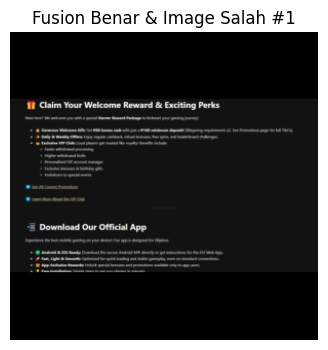

[FILE]: agycasino88.com_page5.png
[TEXT]: claim your welcome reward exciting perks new here welcome you with special starter reward package kickstart your gaming journey generous welcome gift get bonus cash with just minimum deposit wagering requirement see promotions page for full daily weekly offers enjoy regular cashback reload bonuses free spins and leaderboard challenges exclusive vip club loyal players get treated like royalty benefits include faster withdrawal processing higher withdrawal limits personalized vip account manager exclusive bonuses birthday gifts invitations special events see curent promotions learn about the vip club download
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.5435)
[PRED - Image ]: 0 (Prob: 0.0027)
[PRED - Text  ]: 1 (Prob: 0.9716)
------------------------------------------------------------


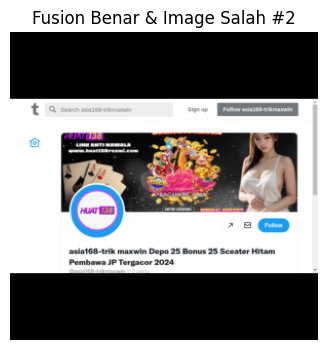

[FILE]: asia168-trikmaxwin.tumblr.com.png
[TEXT]: search asial trikmaxwin sign follow asia trikmaxwin guua linrantivawala huatissresmicon oragmaiic qotg sreaaic huti follow asia trik maxwin depo bonus sceater hitam pembawa tergacor asia oooy
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.9879)
[PRED - Image ]: 0 (Prob: 0.0283)
[PRED - Text  ]: 1 (Prob: 0.9990)
------------------------------------------------------------


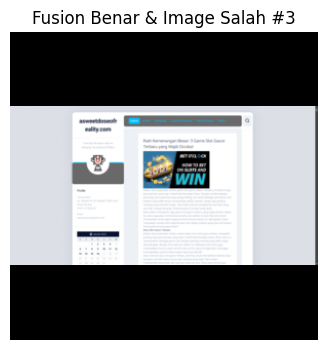

[FILE]: asweetdoseofreality.com.png
[TEXT]: asweetdoseofr home artikel kebijakan syarat ketentuan rekomendasi pesan eality com raih kemenangan besar game slot gacor link slot gacor hari ini menang terus resmi pgslot terbaru yang wajib dicoba beto how bet slots and win profile dalam dunia perjudian online game slot gacor selalu menjadi primadona bagi para pemain yang ingin meraih kemenangan besar dengan perkembangan luhung halim teknologi dan kreativitas para pengembang kini hadir berbagai permainan slot sukajadi sibolga sulut terbaru yang tidak menawarkan grafis menarik tetapi juga peluang phone number menang yang semakin tinggi jika anda mencari pengalaman bermain yang seru dan menguntungkan anda berada di tempat yang tepat kami telah merangkum tiga game slot gacor terbaru yang wajib dicoba selain email
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.5243)
[PRED - Image ]: 0 (Prob: 0.0000)
[PRED - Text  ]: 1 (Prob: 0.9990)
------------------------------------------------------------


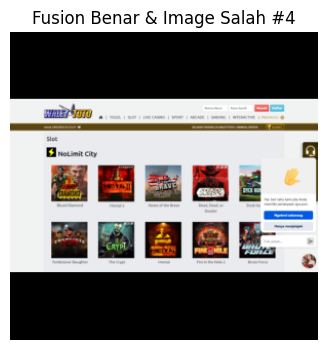

[FILE]: manggishq.com_page1.png
[TEXT]: nama akun kata sandi masuk daftar jiepjojo togel slot live casino sport arcade sabung interactive promosi jumat selamat datang di walettoto minimal deposi event slot nolimit city homes the biood tazli ion duck kuk hai beri tahu kami jika anda blood diamond mental home ofthe brave dead dead duck memiliki pertanyaan apa pun deader ngobrol sekarang menjelajah zciaifp tulis pesan meiitial fires holel ftee tombstone slaughter the mental fire the hole brute force brave hanya
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.9902)
[PRED - Image ]: 0 (Prob: 0.4884)
[PRED - Text  ]: 1 (Prob: 0.9990)
------------------------------------------------------------


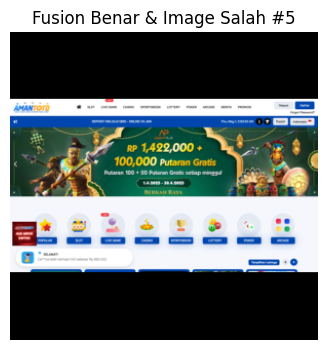

[FILE]: amantoto.ink_page5.png
[TEXT]: hot masuk daftar mani slot live game casino sportsbook lottery poker arcade berita promosi vsenctouel forgot password deposit melalui oris online jam thu may rupiah indonesia advntflay putaran gratis putaran putaran gratis setiap minggul berkah raya hot glub klik untuk daftar popular slot live game casino sportsbook lottery poker arcade selamat xkya telah berhasil sebesar tampilkan lainnya
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.9896)
[PRED - Image ]: 0 (Prob: 0.0523)
[PRED - Text  ]: 1 (Prob: 0.9991)
------------------------------------------------------------


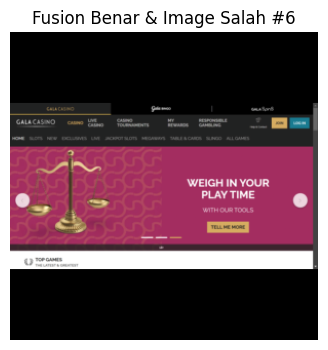

[FILE]: galacasino.com.png
[TEXT]: gala casino gala bingo gala spins gala casino casino live casino responsible join log casino tournaments rewards gambling help contact home slots new exclusives live jackpot slots megaways table cards slingo all games weigh your play time with our tools tellme more top games the latest greatest
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.9888)
[PRED - Image ]: 0 (Prob: 0.0847)
[PRED - Text  ]: 1 (Prob: 0.9989)
------------------------------------------------------------


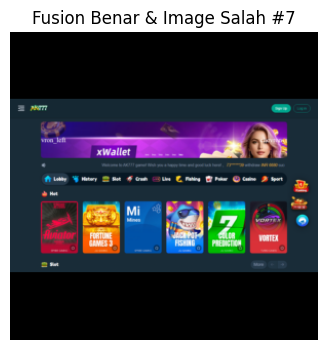

[FILE]: ak777game.com_page1.png
[TEXT]: sign vron left cnevron xwallet welcome game wish you happy time and good luck herel withdraw inr suc lobby history slot crash lve live fishing poker casino sport ranking hot spribe mines vorte aviator fortuke jacimpot culor vortex games fishing prediction spribe caming gannc sfribe caming jili gamng jili gannc turbo games slot more
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.9879)
[PRED - Image ]: 0 (Prob: 0.4857)
[PRED - Text  ]: 1 (Prob: 0.9986)
------------------------------------------------------------


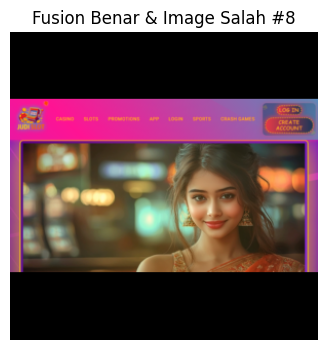

[FILE]: judi-slots.com_page2.png
[TEXT]: log casino slots promotions app login sports crash games create judi slot account
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.9901)
[PRED - Image ]: 0 (Prob: 0.3599)
[PRED - Text  ]: 1 (Prob: 0.9990)
------------------------------------------------------------


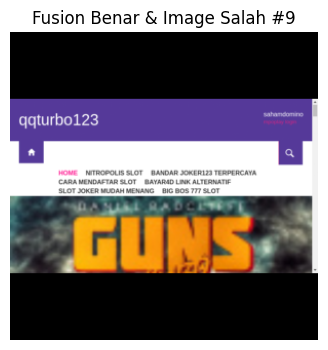

[FILE]: 0555613.slotslou.sbs.png
[TEXT]: sahamdomino qqturbo mpoplay login home nitropolis slot bandar joker terpercaya cara mendaftar slot bayarad link alternatif slot joker mudah menang big bos slot
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.9903)
[PRED - Image ]: 0 (Prob: 0.4190)
[PRED - Text  ]: 1 (Prob: 0.9990)
------------------------------------------------------------


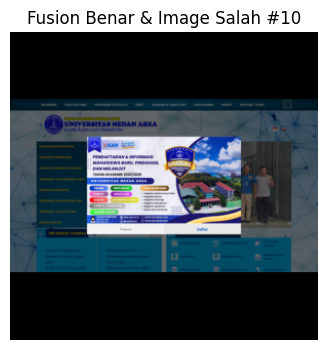

[FILE]: uma.ac.id_home.png
[TEXT]: beranda sekilas uma program unit sarana fasilitas kerjasama arsip virtual tour universitas medan area barsu padha bcliyasblex registrasi mahasiswa ykan kergys beasiswa mahasiswa pendaftaran informasi terakreditasi mahasiswa baru pindahan unggul inforhasi akademik online dan melanjut perguryan tinggi tahun akademik inforhasi icp hybrid class universitas medan area teknik pertanian pascasarjana kalender akadehik fisipol psikologi mogister administrosipublik moglster hukum inforhasi app android uma hukum ekonon bisnjs mogister palkolo mogistcr honajcmen sains teknoloai mogister agribisnis doktorilmu pertonion inforhasi tracer
[LABEL]: 0
[PRED - Fusion]: 0 (Prob: 0.2551)
[PRED - Image ]: 1 (Prob: 0.9466)
[PRED - Text  ]: 0 (Prob: 0.0013)
------------------------------------------------------------

========== ✅ Fusion BENAR & TEXT SALAH ==========


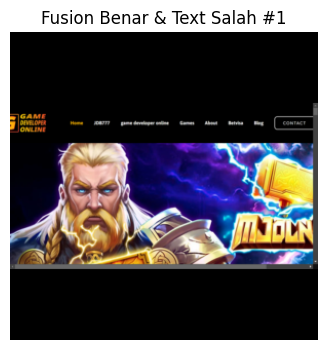

[FILE]: game-developer-online.com.png
[TEXT]: game developer home game developer online games about betvisa contact online imlln blog
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.6715)
[PRED - Image ]: 1 (Prob: 0.9575)
[PRED - Text  ]: 0 (Prob: 0.0633)
------------------------------------------------------------


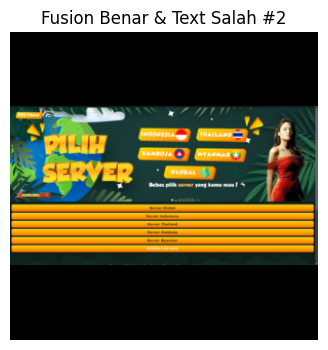

[FILE]: gacorgunung303.college.png
[TEXT]: pos cuan indonesia thailand pli kamboja myanmar sewer global bebas pilih server yang kamu mau gunungs server global server indonesia server thailand server kamboja server myanmar download apk
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.9123)
[PRED - Image ]: 1 (Prob: 0.9996)
[PRED - Text  ]: 0 (Prob: 0.4819)
------------------------------------------------------------


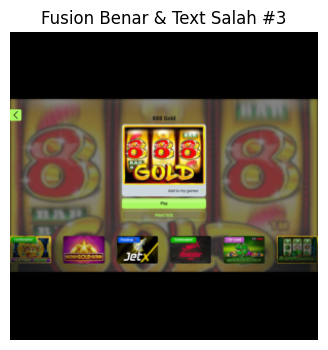

[FILE]: ahadubirr.com_page1.png
[TEXT]: gold add games play practice tournament prizedrop tournament top game uves igodgodgod jet aviator zoeueinghot
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.6583)
[PRED - Image ]: 1 (Prob: 0.8685)
[PRED - Text  ]: 0 (Prob: 0.2853)
------------------------------------------------------------


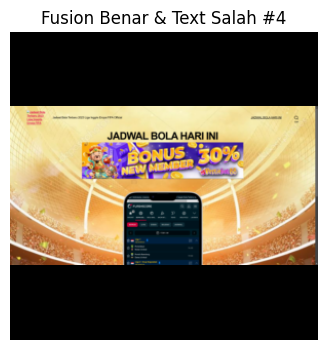

[FILE]: bolabestieupdate.site.png
[TEXT]: jadwal bola ierbaru jadwal bola terbaru liga inggris eropa fifa official jadwalbolaharlini ligainggris cari eropa eifa jadwal bola hari ini neemlecr cesddcceg indonesia livescor sepak bola terkini flashscore favorit sepak bola bas badmint tenis bola voli lainnya semua live odds selesai jadwal liga indonesia persebaya malut united persib bandung dewa united liga grup degradasi indonfsia bonus
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.8048)
[PRED - Image ]: 1 (Prob: 0.9988)
[PRED - Text  ]: 0 (Prob: 0.0066)
------------------------------------------------------------


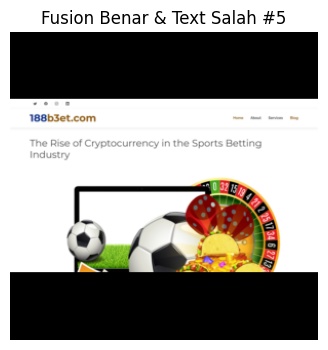

[FILE]: jubise.com_page5.png
[TEXT]: com home about services blog the rise cryptocurrency the sports betting industry
[LABEL]: 1
[PRED - Fusion]: 1 (Prob: 0.6370)
[PRED - Image ]: 1 (Prob: 0.8647)
[PRED - Text  ]: 0 (Prob: 0.1937)
------------------------------------------------------------


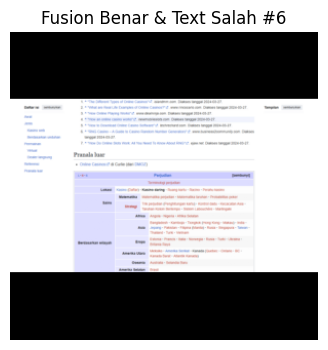

[FILE]: https___id.wikipedia.org_wiki_Kasino_daring_page5.png
[TEXT]: the different types online casinos islandmm com diakses tanggal daftar isi semounyikan what are real life examples online casinos rincocarlo com diakses tanggal tampilan sembunyikan how online playing works dealninja com diakses tanggal awal how online casino works newmobileslots com diakses tanggal jenis how download online casino software techrechard com diakses tanggal kasino web casino guide casino random number generators business community com diakses berdasarkan unduhan tanggal permainan how online slots work all you need know about ejaw net diakses tanggal virtual dealer langsung pranala luar referensi online casinos di curlie dari dmoz pranala
[LABEL]: 0
[PRED - Fusion]: 0 (Prob: 0.2200)
[PRED - Image ]: 0 (Prob: 0.0000)
[PRED - Text  ]: 1 (Prob: 0.9959)
------------------------------------------------------------


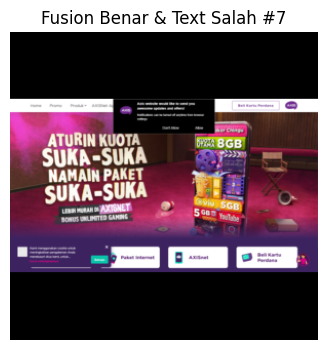

[FILE]: axis.co.id_home.png
[TEXT]: home promo produk axisnet axis website would like send you beli kartu perdana axis awesome updates and offers axis notifications can tumned off anytime from browser settings dont allow allow akor chingu aturin kuota suka suka namain paket suka suka axisnet oviu lebih murah di bonus unlimited gaming kami menggunakan cookie untuk meningkatkan pengalaman anda beli kartu menelusuri situs kami untuk paket internet axisnet baca selengkapnya setuju perdana youtube
[LABEL]: 0
[PRED - Fusion]: 0 (Prob: 0.2826)
[PRED - Image ]: 0 (Prob: 0.0093)
[PRED - Text  ]: 1 (Prob: 0.8547)
------------------------------------------------------------


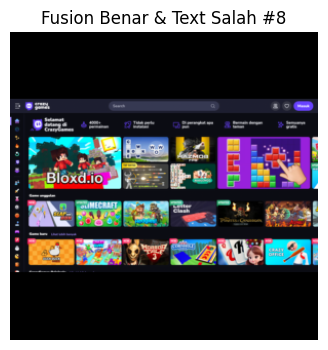

[FILE]: crazygames.co.id_home.png
[TEXT]: craz search masuk games selamat datang di tidak perlu di perangkat apa bermain dengan semuanya permainan instalasi pun teman gratis crazygames hazmob top rated updf bloxdro mahjongg game unggulan new updated updated updated hmecraft eetter clash gdap amd bun hedgilesl raites ciribbeain assemoli tides ofwar game baru lihat lebih banyak new new new new new new nev horror conntole razy fflce ouciqc clicker
[LABEL]: 0
[PRED - Fusion]: 0 (Prob: 0.2262)
[PRED - Image ]: 0 (Prob: 0.0555)
[PRED - Text  ]: 1 (Prob: 0.6037)
------------------------------------------------------------


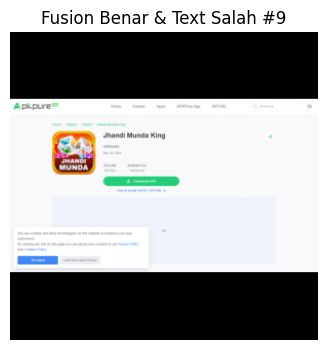

[FILE]: apkpure.net_page8.png
[TEXT]: pkpure home games apps apkpure app aipure apkpure home games casino jhandi munda king jhandi munda king volosonic may jhandi android munda file size android download apk how install xapk apk file use cookies and other technologies this website enhance your user experience clicking link this page you are giving your consent our privacy policy and cookies policy agree learn more about policies any
[LABEL]: 0
[PRED - Fusion]: 0 (Prob: 0.1306)
[PRED - Image ]: 0 (Prob: 0.0001)
[PRED - Text  ]: 1 (Prob: 0.9736)
------------------------------------------------------------

========== ❌ Fusion SALAH ==========


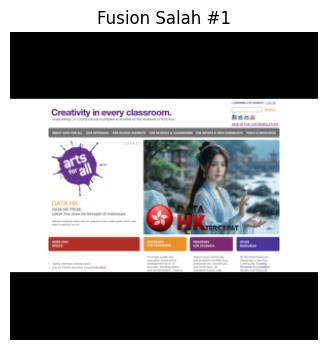

[FILE]: lankfordhotel.com_home.png
[TEXT]: learning exchange log search creativity every classroom empowering county schools prepare all students for the workforce tomorrow sign for qur newsleiter about arts for all our approach for school districts for schools classrooms for artists arts community tools resources all data data prize data untuk live draw tercepat di indonesia nikmati kumpulan tabel data yang bisa kamu pakai gratis untuk main togel hongkong hari ini tercepat news and proerams programs other events for educators for students resources find high quality arts search local community find information education professional arts programs for field trips designing learning spring cal
[LABEL]: 1
[PRED - Fusion]: 0 (Prob: 0.1320)
[PRED - Image ]: 0 (Prob: 0.2225)
[PRED - Text  ]: 0 (Prob: 0.1198)
------------------------------------------------------------


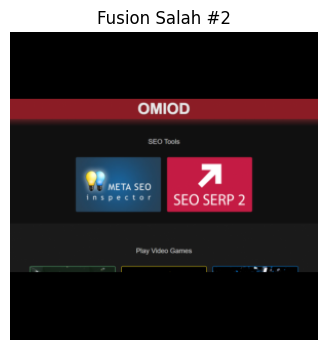

[FILE]: omiod.com_home.png
[TEXT]: omiod seo tools meta seo seo serp play video games
[LABEL]: 0
[PRED - Fusion]: 1 (Prob: 0.6049)
[PRED - Image ]: 1 (Prob: 0.9746)
[PRED - Text  ]: 0 (Prob: 0.0126)
------------------------------------------------------------


In [43]:
# Jalankan evaluasi error analysis
print("\n===== ERROR ANALYSIS =====")
evaluate_and_show_errors(fusion_model, combined_test_loader, device, tokenizer, num_samples_to_show=10)

In [44]:
# Fungsi tambahan untuk analisis lebih detail
def detailed_error_analysis(fusion_model, data_loader, device):
    """
    Analisis error yang lebih detail untuk memahami performance fusion model
    """
    fusion_model.eval()
    
    results = {
        'all_correct': 0,      # Semua model benar
        'fusion_only': 0,      # Hanya fusion yang benar
        'image_only': 0,       # Hanya image yang benar
        'text_only': 0,        # Hanya text yang benar
        'fusion_image': 0,     # Fusion dan image benar, text salah
        'fusion_text': 0,      # Fusion dan text benar, image salah
        'image_text': 0,       # Image dan text benar, fusion salah
        'all_wrong': 0,        # Semua model salah
        'total': 0
    }
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Detailed Error Analysis"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            fused_logits, image_logits, text_logits = fusion_model(images, input_ids, attention_mask)
            
            fused_preds = (torch.sigmoid(fused_logits) > 0.5).long()
            image_preds = (torch.sigmoid(image_logits) > 0.5).long()
            text_preds = (torch.sigmoid(text_logits) > 0.5).long()
            
            for i in range(labels.size(0)):
                label = labels[i].item()
                f_correct = fused_preds[i].item() == label
                i_correct = image_preds[i].item() == label
                t_correct = text_preds[i].item() == label
                
                if f_correct and i_correct and t_correct:
                    results['all_correct'] += 1
                elif f_correct and not i_correct and not t_correct:
                    results['fusion_only'] += 1
                elif not f_correct and i_correct and not t_correct:
                    results['image_only'] += 1
                elif not f_correct and not i_correct and t_correct:
                    results['text_only'] += 1
                elif f_correct and i_correct and not t_correct:
                    results['fusion_image'] += 1
                elif f_correct and not i_correct and t_correct:
                    results['fusion_text'] += 1
                elif not f_correct and i_correct and t_correct:
                    results['image_text'] += 1
                else:
                    results['all_wrong'] += 1
                
                results['total'] += 1
    
    # Print hasil analisis
    print("\n===== DETAILED ERROR ANALYSIS =====")
    for key, value in results.items():
        if key != 'total':
            percentage = (value / results['total']) * 100
            print(f"{key.replace('_', ' ').title()}: {value} ({percentage:.2f}%)")
    
    return results

In [45]:
# Jalankan analisis detail
error_analysis_results = detailed_error_analysis(fusion_model, combined_test_loader, device)

Detailed Error Analysis: 100%|██████████| 44/44 [00:28<00:00,  1.54it/s]


===== DETAILED ERROR ANALYSIS =====
All Correct: 671 (95.86%)
Fusion Only: 0 (0.00%)
Image Only: 0 (0.00%)
Text Only: 1 (0.14%)
Fusion Image: 9 (1.29%)
Fusion Text: 18 (2.57%)
Image Text: 0 (0.00%)
All Wrong: 1 (0.14%)
